In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.optimize import curve_fit

In [2]:
base_dir9 = '../run_sims/diffusion/'
base_dir10 = '../run_sims/reaction_kinetics/'

In [5]:
def line(x,slope):
    return x*slope

# Diffusion

In [8]:
diff_df = pd.read_csv(f'{base_dir9}MSD_vs_time.csv',index_col=0)

In [10]:
diff_df.columns

Index(['time', 'LAT_d0.1_t1_x0.25_rep0', 'LAT_d0.1_t1_x0.25_rep1',
       'LAT_d0.1_t1_x0.25_rep2', 'LAT_d0.1_t1_x0.25_rep3',
       'LAT_d0.1_t1_x0.25_rep4', 'LAT_d0.1_t1_x0.5_rep0',
       'LAT_d0.1_t1_x0.5_rep1', 'LAT_d0.1_t1_x0.5_rep2',
       'LAT_d0.1_t1_x0.5_rep3',
       ...
       'source_d1_t3_x1_rep0', 'source_d1_t3_x1_rep1', 'source_d1_t3_x1_rep2',
       'source_d1_t3_x1_rep3', 'source_d1_t3_x1_rep4', 'source_d1_t10_x1_rep0',
       'source_d1_t10_x1_rep1', 'source_d1_t10_x1_rep2',
       'source_d1_t10_x1_rep3', 'source_d1_t10_x1_rep4'],
      dtype='object', length=151)

In [12]:
diff_info = pkl.load(open(f'{base_dir9}diffusion_info.pkl','rb'))
diff_info

{'D_LAT': 0.043125,
 'D_TCR': 0.064,
 'diff_factor': [0.1, 0.5, 1],
 't_factor': [1, 1, 1, 3, 10],
 'x_factor': [0.25, 0.5, 1, 1, 1],
 'kinds': ['LAT', 'source'],
 'dt_base': 0.000125,
 'dx_base': 0.03}

[0.01665384]
[0.08429064]
[0.18223143]
[0.02502285]
[0.12729435]
[0.25946189]


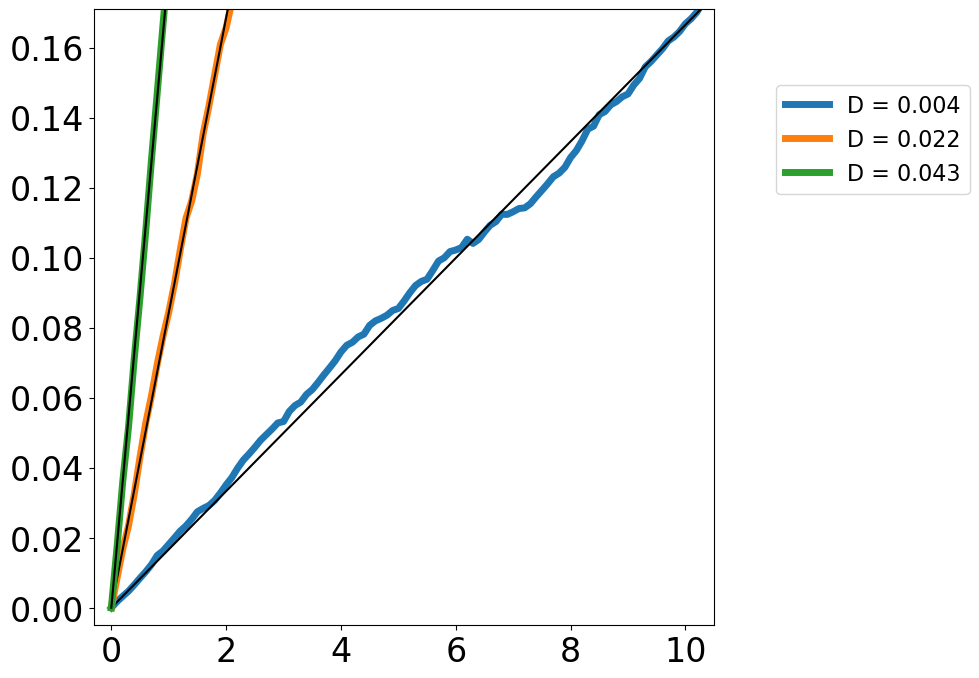

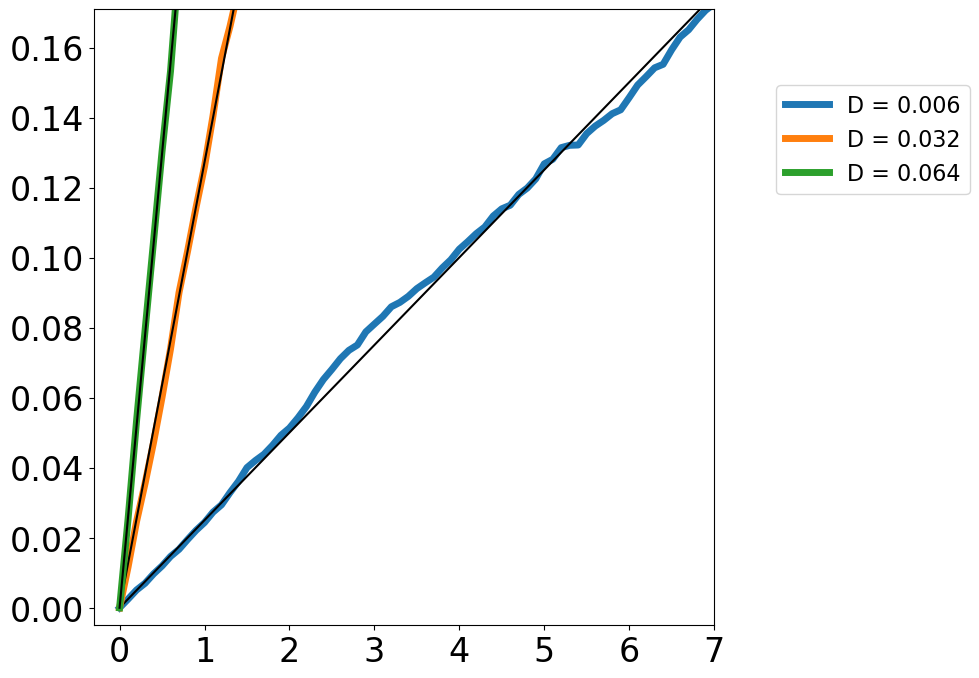

In [14]:
x,y = np.meshgrid(np.arange(151),np.arange(151))
max_MSD = np.mean(((x-75)**2 + (y-75)**2))*(0.03)**2

base_D = {
    'LAT_':diff_info['D_LAT'],
    'source_':diff_info['D_TCR']
}

for mol in ['LAT_','source_']:
    plt.figure(figsize=[8,8])
    for kind in ['d0.1_t1_x1','d0.5_t1_x1','d1_t1_x1']:
        cols = [col for col in diff_df.columns if mol+kind in col]
        plt.plot(diff_df['time'],diff_df[cols].mean(axis=1),label=f'D = {round(base_D[mol]*float(kind.split('_')[0][1:]),3)}',linewidth=5)
        
        idx = diff_df[cols].mean(axis=1) <= max_MSD/20
        params,_ = curve_fit(line,diff_df.loc[idx,'time'],diff_df.loc[idx,cols].mean(axis=1),p0=[0.05])
        print(params)
    
        x = np.linspace(0,120,1000)
        y = line(x,*params)
        plt.plot(x,y,'k-')
    
    # plt.ylim([-0.03*max_MSD,1.1*max_MSD])
    if mol == 'LAT_':
        plt.xlim([-0.3,10.5])
    else:
        plt.xlim([-0.3,7])
    plt.ylim([-0.005,max_MSD/20])
    plt.legend(loc=[1.1,0.7],fontsize=16)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    # plt.plot(plt.xlim(),[max_MSD]*2,'k--')
    plt.savefig(f'{mol}example_MSD_curves.png',bbox_inches='tight',dpi=300)

In [16]:
summary = []
for col in diff_df.columns:
    if col != 'time':
        split = col.split('_')
        mol = split[0]
        D = round(base_D[mol+'_']*float(split[1][1:]),3)
        dx = diff_info['dx_base']*float(split[3][1:])
        dt = diff_info['dt_base']/float(split[2][1:])
        rep = int(split[4][-1])
        
        idx = diff_df[cols].mean(axis=1) <= max_MSD/20
        params,_ = curve_fit(line,diff_df.loc[idx,'time'],diff_df.loc[idx,col],p0=[0.05])

        summary.append([mol,D,dx,dt,rep,params[0]/4])
summary = pd.DataFrame(summary,columns=['mol','true_D','dx','dt','rep','obs_D'])
summary.head()

,mol,true_D,dx,dt,rep,obs_D
0,LAT,0.004,0.0075,0.000125,0,0.004261
1,LAT,0.004,0.0075,0.000125,1,0.003935
2,LAT,0.004,0.0075,0.000125,2,0.004641
3,LAT,0.004,0.0075,0.000125,3,0.004026
4,LAT,0.004,0.0075,0.000125,4,0.004304


In [18]:
0.05*max_MSD

0.171

In [20]:
summary['dx_dt'] = summary.apply(lambda row: f'{row["dt"]*1e6:.3g},   {row["dx"]*1e3:.2g}',axis=1)
summary['obs_ratio'] = summary['obs_D']/summary['true_D']

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
/var/folders/1r/_dnhk2ss6m3fr8s3lgl4kcmw0000gn/T/ipykernel_81044/3729751804.py:7: SyntaxWarning: invalid escape sequence '\D'
  plt.legend(loc=[1.1,0.5],fontsize=16,title='          $\Delta$t ($\mu$s)   $\Delta$x (nm)',title_fontsize=16)


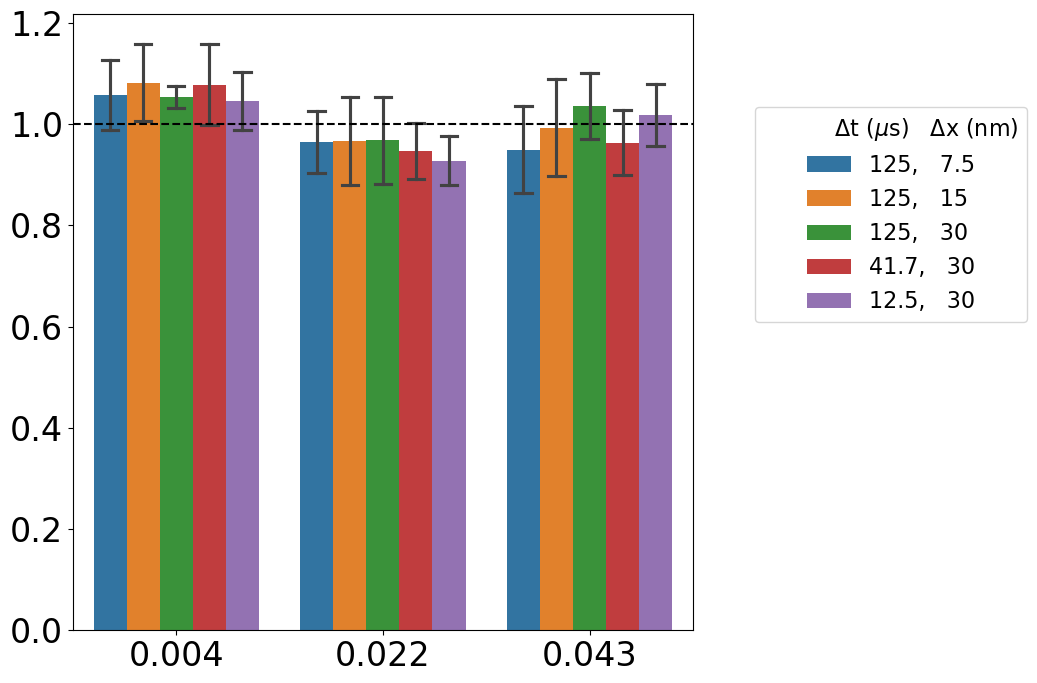

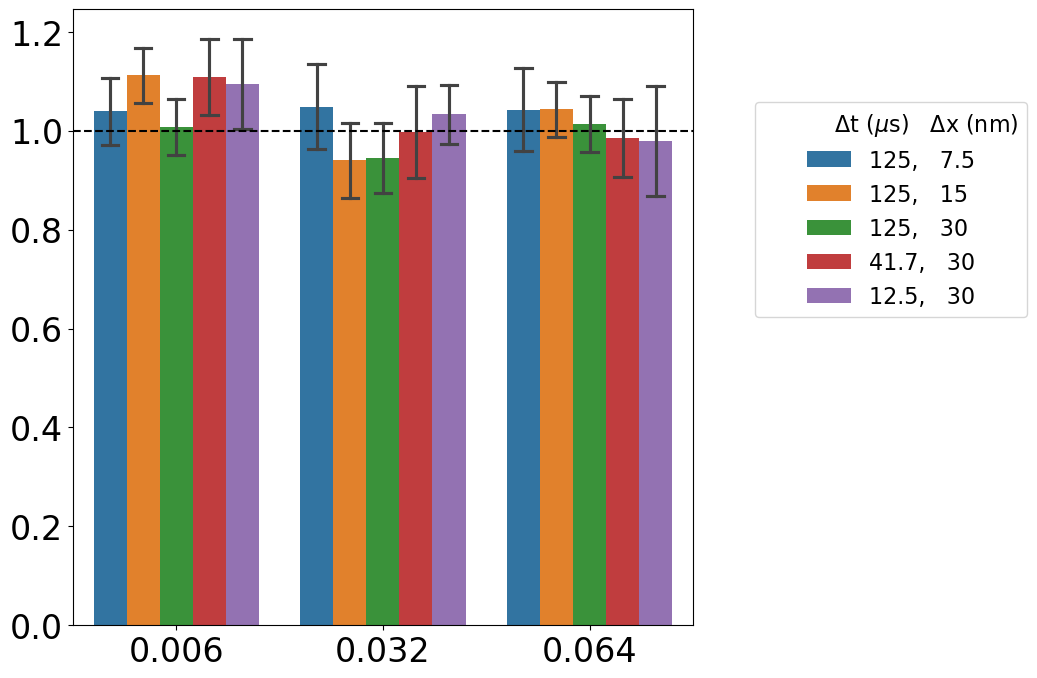

In [22]:
for mol in ['LAT','source']:
    plt.figure(figsize=[8,8])
    sns.barplot(data=summary[summary['mol']==mol],x='true_D',y='obs_ratio',hue='dx_dt',errorbar='sd',capsize=0.4)
    lims = plt.xlim()
    plt.plot(lims,[1,1],'k--')
    plt.xlim(lims)
    plt.legend(loc=[1.1,0.5],fontsize=16,title='          $\Delta$t ($\mu$s)   $\Delta$x (nm)',title_fontsize=16)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(f'{mol}_diff_ratio_barplot.png',bbox_inches='tight',dpi=300)

# Reaction Kinetics

In [24]:
rxn_df = pd.read_csv(f'{base_dir10}dimer_vs_time.csv',index_col=0)
rxn_info = pkl.load(open(f'{base_dir10}rxn_kinetics_info.pkl','rb'))

In [26]:
rxn_df.columns

Index(['time', 't4_on1_frac0_rep0', 't4_on1_frac0_rep1', 't4_on1_frac0_rep2',
       't4_on1_frac0_rep3', 't4_on1_frac0_rep4', 't4_on3_frac0_rep0',
       't4_on3_frac0_rep1', 't4_on3_frac0_rep2', 't4_on3_frac0_rep3',
       ...
       't8_on1_frac9_rep0', 't8_on1_frac9_rep1', 't8_on1_frac9_rep2',
       't8_on1_frac9_rep3', 't8_on1_frac9_rep4', 't40_on1_frac9_rep0',
       't40_on1_frac9_rep1', 't40_on1_frac9_rep2', 't40_on1_frac9_rep3',
       't40_on1_frac9_rep4'],
      dtype='object', length=251)

In [28]:
rxn_info

{'D_LAT': 0.034477203889386444,
 'dt_base': 0.0005,
 'k_off': 0.625,
 'k_on_base': 0.072,
 'concs': [0.4340277777777778,
  0.8680555555555556,
  1.7361111111111112,
  3.4722222222222223,
  6.944444444444445,
  13.88888888888889,
  27.77777777777778,
  55.55555555555556,
  111.11111111111111,
  222.22222222222223],
 't_factors': [4, 4, 4, 8, 40],
 'on_factors': [1, 3, 9, 1, 1]}

In [30]:
def dimerization(t,k_on,k_off,eqm,initial):
    K = k_on/k_off
    M_eq = (1/(4*K))*(np.sqrt(1 + 8*K*initial)-1)
    num = eqm*(1 + 4*K*(initial - 2*eqm))
    den = 2*K*((2*(initial - eqm) + (1/(2*K)))*np.exp((k_off + 4*k_on*M_eq)*t) - 2*eqm)
    return eqm - (num/den)

In [32]:
def eqm_binding(K_D,C_tot):
    frac_dimer = 1 - ((-1 + np.sqrt(1+(8*C_tot)/K_D))/(4/K_D)/C_tot)
    return frac_dimer

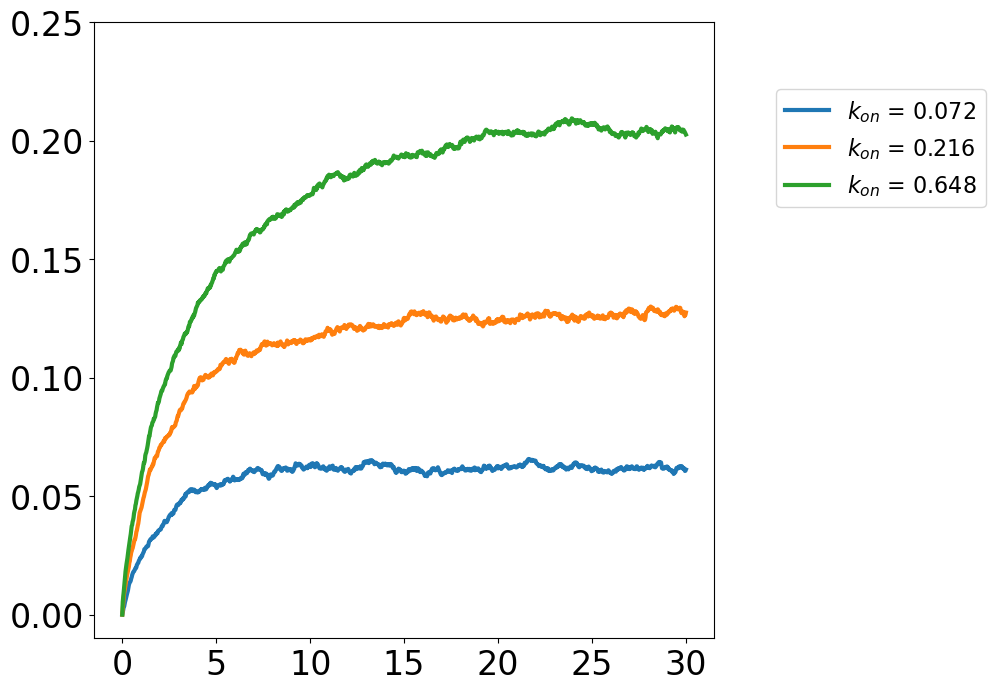

In [34]:
plt.figure(figsize=[8,8])
for kind in ['t4_on1_frac1','t4_on3_frac1','t4_on9_frac1']:

    split = kind.split('_')
    conc = rxn_info['concs'][int(split[2][4:])]
    k_on = rxn_info['k_on_base']*float(split[1][2:])
    
    cols = [col for col in rxn_df.columns if kind in col]
    plt.plot(rxn_df['time'],rxn_df[cols].mean(axis=1),
             label=f'$k_{{on}}$ = {round(k_on,3)}',linewidth=3)

    # conc = rxn_info['concs'][2]
    # params,_ = curve_fit(lambda t,a,b,c: dimerization(t,a,b,c,conc),rxn_df['time'],rxn_df[cols].mean(axis=1),p0=[0.1,0.003,0.2],
    #                      bounds=[0,np.inf],
    #                      maxfev=10000)
    avg = rxn_df[cols].mean(axis=1)
    fwd_rate = k_on*(conc-(2*avg))**2
    rev_rate = rxn_info['k_off']*avg
    # idx = np.abs(fwd_rate) >= np.abs(10*rev_rate)
    # idx = np.zeros(1201).astype(bool)
    # idx[:3] = True
    # params,_ = curve_fit(line,rxn_df.loc[idx,'time'],rxn_df.loc[idx,cols].mean(axis=1),p0=[0.05])
    # print(idx.sum(),params)

    # x = np.linspace(0,120,1000)
    # y = line(x,*params)
    # plt.plot(x,y,'k-')

plt.ylim(-0.01,0.25)
plt.legend(loc=[1.1,0.7],fontsize=16)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(f'example_dimer_curves.png',bbox_inches='tight',dpi=300)

3 [0.03820495]
3 [0.10213977]
3 [0.15983704]


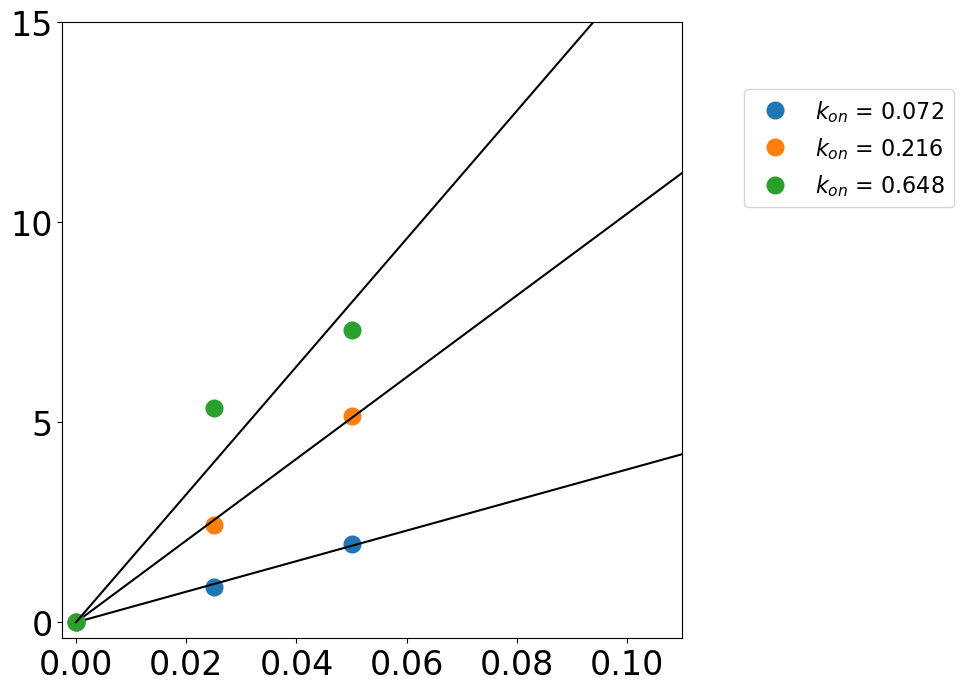

In [36]:
plt.figure(figsize=[8,8])
for kind in ['t4_on1_frac1','t4_on3_frac1','t4_on9_frac1']:

    split = kind.split('_')
    conc = rxn_info['concs'][int(split[2][4:])]
    k_on = rxn_info['k_on_base']*float(split[1][2:])

    idx = np.zeros(1201).astype(bool)
    idx[:3] = True
    
    cols = [col for col in rxn_df.columns if kind in col]
    plt.plot(rxn_df.loc[idx,'time'],rxn_df.loc[idx,cols].mean(axis=1),'o',
             label=f'$k_{{on}}$ = {round(k_on,3)}',linewidth=3,markersize=12)

    # conc = rxn_info['concs'][2]
    # params,_ = curve_fit(lambda t,a,b,c: dimerization(t,a,b,c,conc),rxn_df['time'],rxn_df[cols].mean(axis=1),p0=[0.1,0.003,0.2],
    #                      bounds=[0,np.inf],
    #                      maxfev=10000)
    
    params,_ = curve_fit(line,rxn_df.loc[idx,'time'],rxn_df.loc[idx,cols].mean(axis=1),p0=[0.05])
    print(idx.sum(),params)

    x = np.linspace(0,120,1000)
    y = line(x,*params)
    plt.plot(x,y,'k-')

plt.xlim([-0.0025,0.11])
plt.ylim(-0.0004,0.015)
plt.legend(loc=[1.1,0.7],fontsize=16)
plt.xticks(fontsize=24)
plt.yticks([0,0.005,0.01,0.015],[0,5,10,15],fontsize=24)
plt.savefig(f'example_dimer_curves_zoom.png',bbox_inches='tight',dpi=300)

In [38]:
summary = []
for col in rxn_df.columns:
    if col != 'time':
        split = col.split('_')
        dt = (5e-4)/float(split[0][1:])
        k_on = rxn_info['k_on_base']*float(split[1][2:])
        conc = rxn_info['concs'][int(split[2][4:])]
        rep = int(split[3][-1])

        expected_eqm = eqm_binding(32*rxn_info['k_on_base']/k_on, conc)

        # idx = rxn_df[col] <= expected_eqm/10
        idx = np.zeros(1201).astype(bool)
        idx[:3] = True
        if idx.sum() >= 3:
            params,_ = curve_fit(line,rxn_df.loc[idx,'time'],rxn_df.loc[idx,col],p0=[0.05])
        else:
            params = [np.nan]

        eqm = rxn_df[col].iloc[-100:].mean()

        summary.append([dt,k_on,conc,rep,params[0],eqm])
summary = pd.DataFrame(summary,columns=['dt','true_k_on','conc','rep','rate','eqm'])
summary.head()

/var/folders/1r/_dnhk2ss6m3fr8s3lgl4kcmw0000gn/T/ipykernel_81044/2260314728.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params,_ = curve_fit(line,rxn_df.loc[idx,'time'],rxn_df.loc[idx,col],p0=[0.05])


,dt,true_k_on,conc,rep,rate,eqm
0,0.000125,0.072,0.434028,0,-3.316346e-315,0.013713
1,0.000125,0.072,0.434028,1,2.728925e-02,0.020326
2,0.000125,0.072,0.434028,2,1.949232e-02,0.019171
3,0.000125,0.072,0.434028,3,1.949232e-02,0.016895
4,0.000125,0.072,0.434028,4,-3.316346e-315,0.017762


In [40]:
summary['dt_k'] = summary.apply(lambda row: f'{row["dt"]*1e6:.3g}, {row["true_k_on"]:.3}',axis=1)
summary['frac_dimer'] = 2*summary['eqm']/summary['conc']

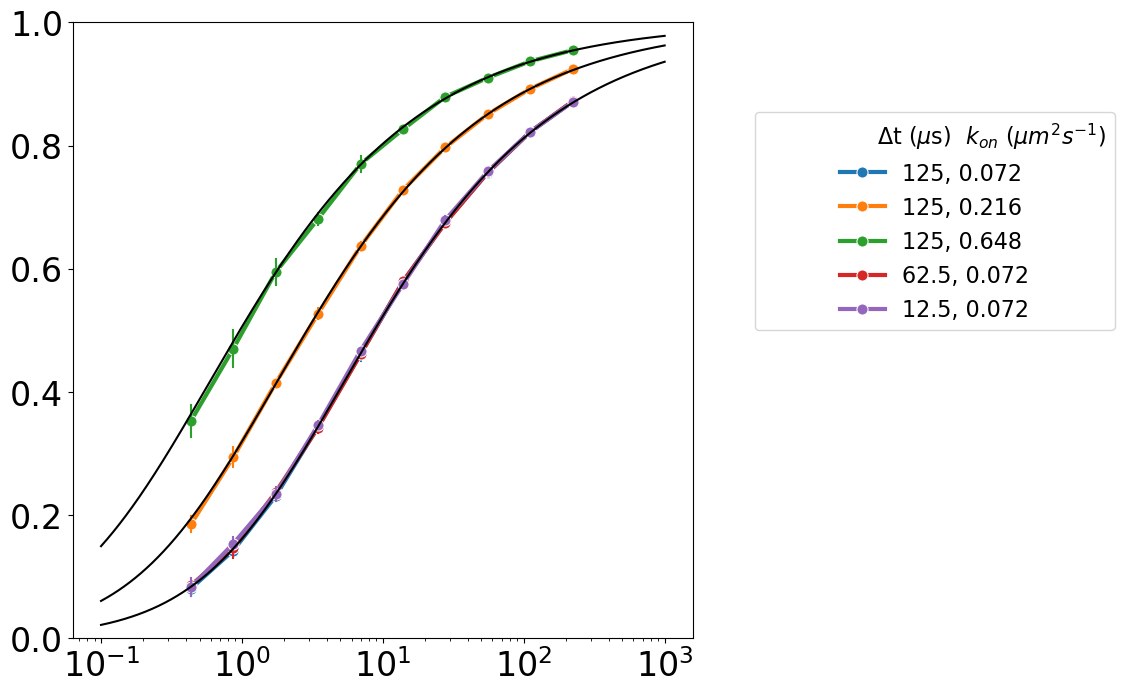

In [42]:
plt.figure(figsize=[8,8])
sns.lineplot(data=summary,x='conc',y='frac_dimer',hue='dt_k',marker='o',linewidth=3,markersize=8,errorbar='sd',err_style='bars')

C_tot = np.logspace(-1,3,1000)
for k_on in summary['true_k_on'].unique():
    plt.plot(C_tot,eqm_binding(rxn_info['k_off']/k_on,C_tot),'k-')
plt.semilogx()
plt.legend(loc=[1.1,0.5],fontsize=16,title='                $\\Delta$t ($\\mu$s)  $k_{on}$ ($\\mu m^{2} s^{-1}$)',title_fontsize=16)
plt.ylim([0,1])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'eqm_dimer_vs_conc.png',bbox_inches='tight',dpi=300)

0.072 2.0254146218482885 0.037385054418425726
0.21599999999999997 1.9314178053011548 0.023001272785095905
0.6479999999999999 1.9122391334067552 0.021658253465865286


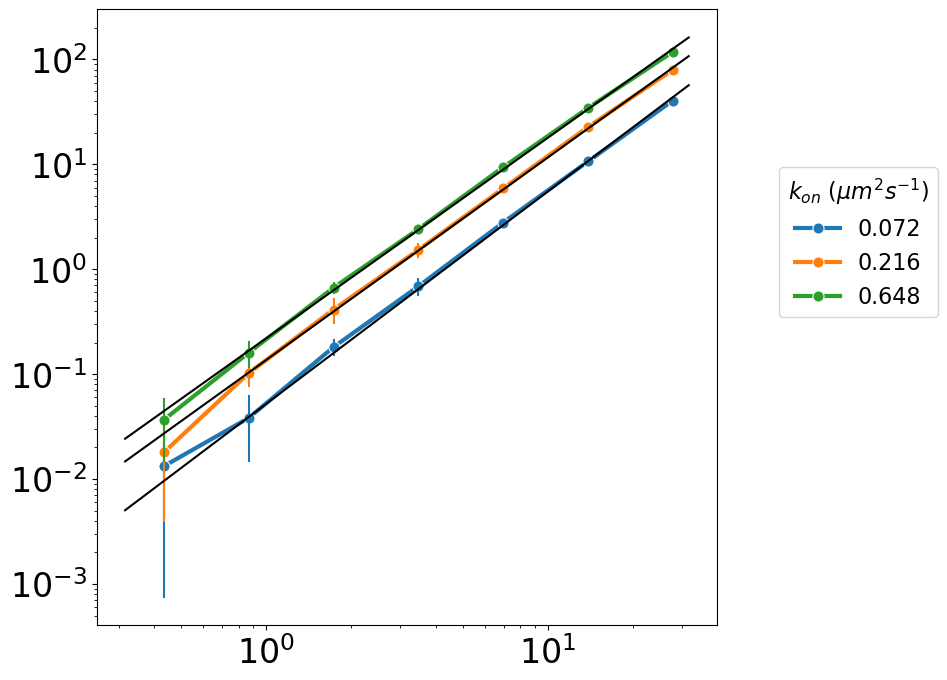

In [44]:
summary['k_on_round'] = np.round(summary['true_k_on'],3)

max_conc = 40
min_conc = 0.5

plt.figure(figsize=[8,8])
sns.lineplot(data=summary[(summary['dt']==0.000125)&(summary['conc']<max_conc)],x='conc',y='rate',
             hue='k_on_round',marker='o',linewidth=3,markersize=8,errorbar='sd',err_style='bars',palette='tab10')

means = []
covs = []
for k in summary['true_k_on'].unique():
    subset = summary[(summary['dt']==0.000125)&(summary['true_k_on']==k)&(summary['conc']<max_conc)&(summary['conc']>min_conc)]
    params,cov = np.polyfit(np.log10(subset['conc']),np.log10(subset['rate']),1,cov=True)
    print(k,params[0], np.sqrt(cov[0,0]))
    x = np.logspace(-0.5,1.5,1000)
    y = (10**params[1])*(x**params[0])
    plt.plot(x,y,'k-')

    means.append(params[0])
    covs.append(cov[0,0])
plt.loglog()
plt.legend(loc=[1.1,0.5],fontsize=16,title='$k_{on}$ ($\\mu m^{2} s^{-1}$)',title_fontsize=16)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'rate_vs_conc.png',bbox_inches='tight',dpi=300)

In [46]:
print(np.mean(means))
print(np.sqrt(np.sum(covs))/len(covs))

1.9563571868520662
0.016315571249558274


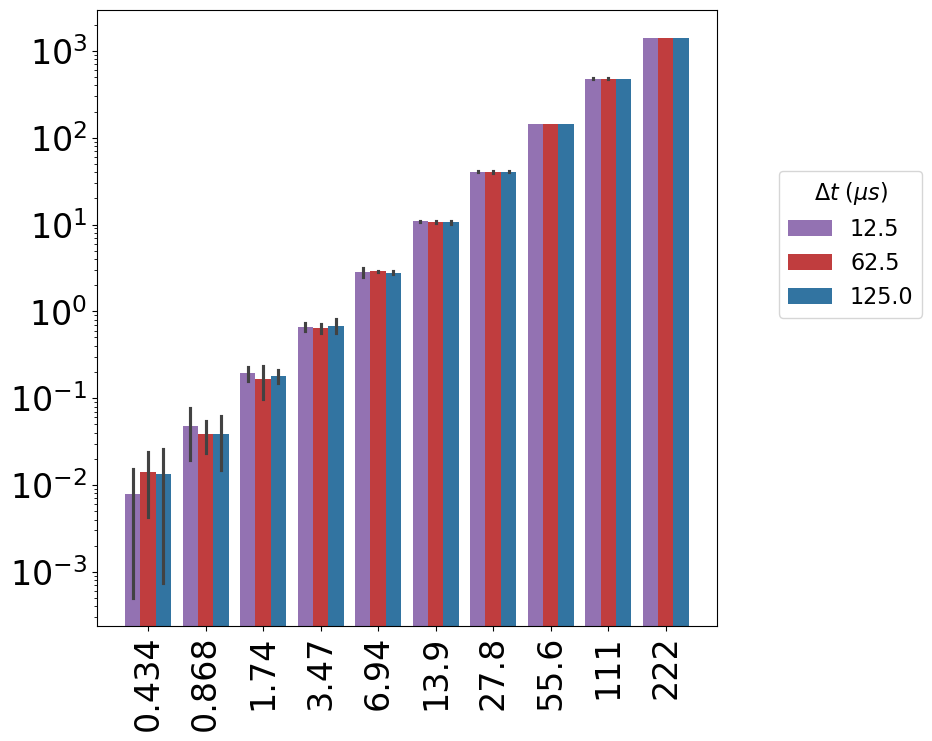

In [48]:
summary['dt_round'] = summary['dt']*1e6
summary['conc_round'] = [f'{x:.3g}' for x in summary['conc']]

tab10 = plt.get_cmap('tab10')
max_conc = 40

plt.figure(figsize=[8,8])
sns.barplot(data=summary[(summary['true_k_on']==0.072)],x='conc_round',y='rate',
             hue='dt_round',errorbar='sd',palette=[tab10(4),tab10(3),tab10(0)])
plt.semilogy()
plt.legend(loc=[1.1,0.5],fontsize=16,title='$\\Delta t$ ($\\mu s$)',title_fontsize=16)
plt.xticks(fontsize=24,rotation=90)
plt.yticks(fontsize=24)
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'rate_bar_plot.png',bbox_inches='tight',dpi=300)

In [50]:
rxn_df

,time,t4_on1_frac0_rep0,t4_on1_frac0_rep1,t4_on1_frac0_rep2,t4_on1_frac0_rep3,t4_on1_frac0_rep4,t4_on3_frac0_rep0,t4_on3_frac0_rep1,t4_on3_frac0_rep2,t4_on3_frac0_rep3,...,t8_on1_frac9_rep0,t8_on1_frac9_rep1,t8_on1_frac9_rep2,t8_on1_frac9_rep3,t8_on1_frac9_rep4,t40_on1_frac9_rep0,t40_on1_frac9_rep1,t40_on1_frac9_rep2,t40_on1_frac9_rep3,t40_on1_frac9_rep4
0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.025,0.000000,0.000487,0.000487,0.000487,0.000000,0.000975,0.000487,0.000000,0.000000,...,47.068598,47.218689,47.223562,47.232821,47.027664,47.043746,47.333207,47.319562,47.287887,47.055441
2,0.050,0.000000,0.001462,0.000975,0.000975,0.000000,0.001462,0.000975,0.000000,0.000487,...,64.908946,64.849495,64.988378,64.904561,65.005921,64.583912,65.175504,65.063910,64.837312,64.657983
3,0.075,0.000000,0.001462,0.000975,0.000975,0.000487,0.001949,0.001949,0.000975,0.000975,...,74.378804,74.227251,74.345180,74.198987,74.353464,74.022582,74.472367,74.458723,74.196551,73.981161
4,0.100,0.000000,0.001462,0.001462,0.000975,0.000487,0.002437,0.001949,0.001462,0.001462,...,80.043760,80.098339,80.020369,79.978948,80.066664,79.834705,80.155841,80.143171,79.970177,79.823984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,29.900,0.017056,0.020467,0.018518,0.015594,0.015594,0.043858,0.037523,0.035573,0.043370,...,96.917777,96.932396,96.819828,96.802285,96.877817,96.515260,96.880741,96.853452,96.836883,96.702874
1197,29.925,0.017543,0.021929,0.018518,0.016568,0.016081,0.043370,0.037523,0.035573,0.042883,...,96.910954,96.920700,96.835909,96.790589,96.845168,96.551321,96.927523,96.816416,96.843218,96.717493
1198,29.950,0.017543,0.022903,0.018030,0.016568,0.016081,0.043370,0.037523,0.036548,0.043858,...,96.925573,96.879279,96.832985,96.826163,96.901208,96.544011,96.936782,96.789127,96.791564,96.678021
1199,29.975,0.017543,0.022416,0.018030,0.016568,0.016081,0.043858,0.037035,0.036548,0.043858,...,96.932883,96.884152,96.844193,96.813980,96.917289,96.587382,96.984050,96.782305,96.786203,96.647808
